In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#cmap = project_cmap()

In [4]:
model = HexagonalGCs(ncells=3)
phases = np.array([[-0.4,0],[0.2,0.2],[0.2,-0.3]])
model.set_phases(phases)
def plane_waves(model,r):
    activity = torch.cos((r[:, None] - model.phases[None]) @ model.ks.T)
    #activity = torch.sum(activity, axis=-1)  # sum plane waves
    activity = (2 / 3) * (activity / 3 + 0.5)  # Solstad2006 scaling
    #activity = self.relu(activity) if self.relu else activity
    return activity.detach().numpy(), torch.sum(activity, axis=-1).detach().numpy()

In [5]:
res = 400
boxsize=(-1.1,1,-1,1)
rs = np.mgrid[boxsize[0]:boxsize[1]:complex(res),boxsize[2]:boxsize[3]:complex(res)].reshape(2,-1).T
rs_t = torch.tensor(rs,dtype=torch.float32)
activity, g = plane_waves(model,rs_t)
activity.shape, rs_t.shape

((160000, 3, 3), torch.Size([160000, 2]))

### Figure 1, A) -> top row
Shows mathematically modelled grid cells

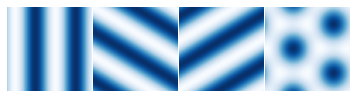

In [6]:
figsize = set_size(fraction=(1,1/4),mode='square')
fig,axs = plt.subplots(ncols=4,figsize=figsize)
axs[0].imshow(activity[:,0,0].reshape(res,res).T,origin='lower')
axs[1].imshow(activity[:,0,1].reshape(res,res).T,origin='lower')
axs[2].imshow(activity[:,0,2].reshape(res,res).T,origin='lower')#,cmap=project_cmap())
axs[3].imshow(g[:,0].reshape(res,res).T,origin='lower')
[ax.axis('off') for ax in axs];
plt.subplots_adjust(hspace=0)
#plt.subplots_adjust(wspace=0,hspace=0)
padding=0.005
[axs[i].set_position((0.25*i+padding,0+padding,0.25-padding,1-padding)) for i in range(len(axs))];
fig.savefig('../results/solstad-grid-cells.png')#,bbox_inches='tight')

### Figure 1, B) -> Middle row
Shows phases and unit cell

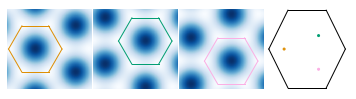

In [7]:
color_triple = [color_cycler[1], color_cycler[2], color_cycler[6]]
figsize = set_size(fraction=(1,1/4),mode='square')
fig,axs = plt.subplots(ncols=4,figsize=figsize)
for i in range(3):
    axs[i].imshow(g[:,i].reshape(res,res).T,origin='lower',extent=boxsize)#,cmap=project_cmap())
    model.unit_cell.plot(fig,axs[i],center=phases[i],color=color_triple[i])
axs[3].scatter(*model.phases.detach().numpy().T,color=color_triple,s=4)
model.unit_cell.plot(fig,axs[3],color='black')
[ax.axis('off') for ax in axs];
#plt.subplots_adjust(wspace=0,hspace=0)
plt.subplots_adjust(wspace=0.05,hspace=0.05)
#[axs[i].set_position((0.25*i,0,0.25,1)) for i in range(len(axs))];
[axs[i].set_position((0.25*i+padding,0+padding,0.25-padding,1-padding)) for i in range(len(axs))];
fig.savefig('../results/intro-unit-cell.png')#,bbox_inches='tight')

### Fig 1, C) -> Bottom row
Shows how 3 cells' spatial representation (population vector) correlates in space. Indicates whether it is unique within and outside the unit cell

In [8]:
def popvec_correlate(model,res=100,metric='correlate'):
    """
    Population vector correlation
    """
    import copy
    hexagon1 = copy.deepcopy(model.unit_cell)
    hexagon1.center += 2*model.unit_cell.basis[0]
    hexagon2 = copy.deepcopy(model.unit_cell)
    hexagon2.center += 2*model.unit_cell.basis[1]
    hpoints = np.concatenate([model.unit_cell.center+model.unit_cell.hpoints, hexagon1.center+hexagon1.hpoints, 
                              hexagon2.center+hexagon2.hpoints])
    # square enclosing of the three hexagons
    square_enclosing = np.array(list(zip(np.min(hpoints,axis=0), np.max(hpoints,axis=0)))).flatten()
    grid = np.mgrid[square_enclosing[0]:square_enclosing[1]:complex(res),
                    square_enclosing[2]:square_enclosing[3]:complex(res)]
    grid = grid.reshape(2,-1).T
    origin_idx = np.argmin(np.linalg.norm(grid,axis=-1))
    #origin_idx = 4543
    grid_t = torch.tensor(grid,dtype=torch.float32)
    activity = model(grid_t).detach().numpy()
    if metric == 'correlate':
        corr = activity @ activity[origin_idx] # correlate with activity at center -> mesh at idx 0
    elif metric == 'euclidean':
        corr = np.linalg.norm(activity - activity[origin_idx],axis=-1)
    # is in union of the three hexagons
    hexagons = [model.unit_cell, hexagon1, hexagon2]
    mask = np.zeros(res**2).astype(bool)
    for hexagon in hexagons:
        mask = mask | hexagon.is_in_hexagon(grid)
    masked_corr = corr * mask
    masked_corr[~mask] = np.nan # make transparent background
    return corr, mask, square_enclosing, grid[origin_idx], grid, activity

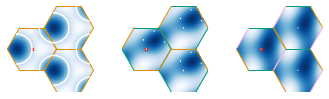

In [9]:
# plotting inits
figsize = set_size(fraction=(1,1/4),mode='square')
fig,axs = plt.subplots(ncols=3,figsize=figsize)
[ax.axis('off') for ax in axs];
plt.subplots_adjust(wspace=0.05,hspace=0.05)
[axs[i].set_position((1/3*i+padding,0+padding,1/3-padding,1-padding)) for i in range(len(axs))];

centers = [model.unit_cell.center, model.unit_cell.center+2*model.unit_cell.basis[0], 
           model.unit_cell.center+2*model.unit_cell.basis[1]]
# ax 0
colors = [color_triple[:1]*6,color_triple[:2]*3,color_triple*2]
for i in range(3):
    model.set_phases(phases[:i+1])
    corr, corr_mask, square_enclosing, center, grid, activity = popvec_correlate(model,res=res,metric='correlate')
    corr[~corr_mask] = np.nan
    axs[i].imshow(corr.reshape(res,res).T,origin='lower',extent=square_enclosing)
    #dists = np.linalg.norm(activity,axis=-1)
    dists, dists_mask, _, _, _, _ = popvec_correlate(model,res=res,metric='euclidean')
    epsilon=1e-2
    levels=[np.sort(np.unique(dists[dists_mask]))[0],np.sort(np.unique(dists[dists_mask]))[1]+epsilon]
    model.unit_cell.plot(fig,axs[i],colors=colors[i])#,linewidth=1.5)
    model.unit_cell.plot(fig,axs[i],center=centers[1],colors=colors[i])#,linewidth=1.5)
    model.unit_cell.plot(fig,axs[i],center=centers[2],colors=colors[i])#,linewidth=1.5)
    axs[i].scatter(*center,s=10,color='red',marker='x') # origin
    axs[i].contour(np.ma.masked_array(dists.reshape(res,res),mask=~dists_mask).T,
                   origin='lower',levels=levels,extent=square_enclosing,colors='white')
    #axs[i].set_aspect('auto')

fig.savefig('../results/pop-vec-ambiguity.png')#,bbox_inches='tight')#,dpi=150)